In [ ]:
#install category encoders
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
#Installs DGL Python package for deep learning graph operations.
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 17.5 MB/s eta 0:00:00


In [ ]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
#Reads CSV data into a pandas DataFrame from 'NF-BoT-IoT.csv' file.
data = pd.read_csv('/content/NF-BoT-IoT.csv')

In [ ]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600095,192.168.100.46,80,192.168.100.5,80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,192.168.100.5,0,192.168.100.3,0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,192.168.100.7,365,192.168.100.3,565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,192.168.100.3,50850,13.54.166.67,8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [ ]:
#Assigns random IPv4 addresses to 'IPV4_SRC_ADDR' column in DataFrame.
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
#Converts specified columns in DataFrame to string data type.

data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [ ]:
#Combines IP addresses and port numbers into single string format.
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [ ]:
#remove 'L4_SRC_PORT' and 'L4_DST_PORT' columns from DataFrame 'data'.
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [ ]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.21.192.25:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,172.25.64.21:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,172.23.104.158:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,172.30.238.137:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,172.19.145.13:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
600095,172.16.212.223:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,172.24.107.25:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,172.19.212.133:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,172.25.147.197:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [ ]:

#This code removes the 'Label' column from the DataFrame 'data'.
data.drop(columns=['Label'],inplace = True)

In [ ]:
#This code renames the 'Attack' column to 'label' in the DataFrame.
data.rename(columns={"Attack": "label"},inplace = True)

In [ ]:
#Converts categorical labels to numerical values using LabelEncoder in scikit-learn.
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [ ]:
# Assigning the 'label' attribute from the 'data' object to the variable 'label'
label = data.label

In [ ]:
# Removing the 'label' column from the DataFrame 'data' in place
data.drop(columns=['label'],inplace = True)

In [ ]:
# Creating a StandardScaler instance for feature standardization or normalization
scaler = StandardScaler()

In [ ]:
# Concatenating the 'data' DataFrame and 'label' object along the columns (axis=1)
data =  pd.concat([data, label], axis=1)

In [ ]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.21.192.25:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0
1,172.25.64.21:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,4
2,172.23.104.158:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0
3,172.30.238.137:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0
4,172.19.145.13:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0
...,...,...,...,...,...,...,...,...,...,...,...
600095,172.16.212.223:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0
600096,172.24.107.25:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0
600097,172.19.212.133:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0
600098,172.25.147.197:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0


In [ ]:
# Splitting the dataset into training and testing sets with 70% for training and 30% for testing
# Setting a random seed (random_state=123) for reproducibility and using stratified sampling based on the 'label'
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [ ]:
# Applying target encoding to categorical columns ('TCP_FLAGS', 'L7_PROTO', 'PROTOCOL') in the training data
# Target encoding is a method that replaces categorical values with the mean of the target variable (in this case, 'y_train') for each category.
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [ ]:
# Display the transformed training data after target encoding
print(X_train)

               IPV4_SRC_ADDR         IPV4_DST_ADDR  PROTOCOL  L7_PROTO  \
592389    172.20.67.62:57470      192.168.100.3:80  2.675586  1.813847   
541914   172.30.113.38:53426      192.168.100.3:80  2.675586  1.813847   
393332   172.18.162.95:60855    192.168.100.6:9080  2.675586  2.933526   
180488  172.23.188.132:14323   192.168.100.3:12139  2.675586  2.933526   
207769  172.23.238.106:40317    192.168.100.5:5357  2.675586  2.933526   
...                      ...                   ...       ...       ...   
96131      172.22.7.69:57963    192.168.100.5:1027  2.675586  2.933526   
583684  172.17.187.163:54248      192.168.100.3:80  2.675586  1.813847   
599529   172.23.213.97:43797  192.168.100.150:4433  2.675586  2.933526   
352726    172.30.59.10:33197      192.168.100.5:90  2.675586  2.933526   
566386     172.22.43.5:48166      192.168.100.3:80  2.675586  1.813847   

        IN_BYTES  OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_FLAGS  \
592389      3612        718       13         4   2

In [ ]:
# Normalizing selected numerical columns in the training data using the StandardScaler
# The selected columns exclude 'label' to avoid scaling the target variable
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
# Creating a new column 'h' in the training data containing lists of values from normalized numerical columns
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
592389,172.20.67.62:57470,192.168.100.3:80,0.256954,-1.668013,-0.010775,-0.007610,0.002649,-0.008687,-1.420647,-2.082482,3,"[-0.008687378732836464, -0.010775447906154435,..."
541914,172.30.113.38:53426,192.168.100.3:80,0.256954,-1.668013,-0.015998,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,1,"[-0.003471109481788205, -0.015997749788891628,..."
393332,172.18.162.95:60855,192.168.100.6:9080,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[-0.02433618648598124, -0.01743253012037605, 0..."
180488,172.23.188.132:14323,192.168.100.3:12139,0.256954,0.565451,-0.017440,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[-0.02433618648598124, -0.017439993217028764, ..."
207769,172.23.238.106:40317,192.168.100.5:5357,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3,"[-0.02433618648598124, -0.01743253012037605, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
96131,172.22.7.69:57963,192.168.100.5:1027,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496290,3,"[-0.02433618648598124, -0.01743253012037605, 0..."
583684,172.17.187.163:54248,192.168.100.3:80,0.256954,-1.668013,-0.016132,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,1,"[-0.003471109481788205, -0.016132085528640493,..."
599529,172.23.213.97:43797,192.168.100.150:4433,0.256954,0.565451,-0.017403,-0.008378,-0.045641,-0.024336,0.676025,0.496292,4,"[-0.02433618648598124, -0.01740267773376519, 0..."
352726,172.30.59.10:33197,192.168.100.5:90,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496289,3,"[-0.02433618648598124, -0.01743253012037605, 0..."


In [ ]:
# Creating a MultiGraph 'G' from the edges of the DataFrame 'X_train'
# Nodes are identified by 'IPV4_SRC_ADDR' and 'IPV4_DST_ADDR', and edge attributes include 'h' and 'label'
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [ ]:
print(G)

MultiGraph with 433116 nodes and 420070 edges


In [ ]:
# Converting the graph 'G' from undirected to directed
G = G.to_directed()

In [ ]:
print(G)

MultiDiGraph with 433116 nodes and 840140 edges


In [ ]:
# Creating a DGLGraph from the NetworkX graph 'G' while retaining edge attributes 'h' and 'label'
G = from_networkx(G,edge_attrs=['h','label'] )

In [ ]:
print(G)

Graph(num_nodes=433116, num_edges=840140,
      ndata_schemes={}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [ ]:

# Assigning a tensor of ones to the 'h' node attribute in the DGLGraph 'G'
# The tensor shape matches the number of nodes and the number of columns in the 'h' edge attribute
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
print(G)

Graph(num_nodes=433116, num_edges=840140,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [ ]:
# Assigning a tensor of True values to the 'train_mask' edge attribute in the DGLGraph 'G'
# The tensor length matches the number of edges in the graph
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
print(G)

Graph(num_nodes=433116, num_edges=840140,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})


In [ ]:
# Accessing the values stored in the 'train_mask' edge attribute of the DGLGraph 'G'
G.edata['train_mask']

tensor([True, True, True,  ..., True, True, True])

In [ ]:
print(G)

Graph(num_nodes=433116, num_edges=840140,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool)})


In [ ]:
# Compute accuracy by comparing the model's predicted class indices with the actual labels
# The result is the mean accuracy across all samples
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
# Definition of a single GraphSAGE layer module
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        # Weight matrix for message aggregation, combining node and edge features
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        # Weight matrix for updating node features based on aggregated messages
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        # Message function for aggregating information from neighboring nodes and edges
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            # Equation 4: Aggregating messages from neighbors
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            # Equation 5: Updating node features with aggregated messages
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']

# Definition of the overall GraphSAGE model
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        # List to store the GraphSAGE layers
        self.layers = nn.ModuleList()
        # First GraphSAGE layer with input dimensions, edge dimensions, output dimensions, and activation function
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        # Second GraphSAGE layer with adjusted input and output dimensions
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
      # Forward pass through each GraphSAGE layer
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            # Update node features using the current GraphSAGE layer
            nfeats = layer(g, nfeats, efeats)
            # Summing node features along the second dimension (across nodes) for the final output
        return nfeats.sum(1)

In [ ]:
# Definition of a Multi-Layer Perceptron (MLP) Predictor module for graph edge scoring
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        # Fully connected layer to compute scores based on concatenated node features
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
      # Extracting node features from source and destination nodes
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # Concatenating node features and passing through the fully connected layer
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
          # Setting node features in the graph to input features 'h'
            graph.ndata['h'] = h
            # Applying the 'apply_edges' function to compute scores for each edge
            graph.apply_edges(self.apply_edges)
             # Returning the computed scores for each edge
            return graph.edata['score']

In [ ]:
# Reshaping node features in the DGLGraph 'G' to have an additional dimension
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
# Reshaping edge features in the DGLGraph 'G' to have an additional dimension
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [ ]:
# Definition of a complete neural network model
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        # GraphSAGE layer for node feature processing
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        # MLP predictor for edge scoring
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
      # Forward pass through the GraphSAGE layer
        h = self.gnn(g, nfeats, efeats)
         # Forward pass through the MLP predictor to obtain edge scores
        return self.pred(g, h)

In [ ]:
# Computing class weights for balanced class distribution
# This is useful for handling class imbalance in machine learning tasks
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(G.edata['label'].cpu().numpy()),
                                                 y = G.edata['label'].cpu().numpy())

In [ ]:
# Defining CrossEntropyLoss criterion for a classification task with class weights
# Class weights are applied to handle imbalanced class distribution during training
import torch as th
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html


In [ ]:
pip list|grep dgl

dgl                              1.1.2+cu118
dglgo                            0.0.2


In [ ]:
pip uninstall dgl

Found existing installation: dgl 1.1.2+cu118
Uninstalling dgl-1.1.2+cu118:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/dgl-1.1.2+cu118.dist-info/*
    /usr/local/lib/python3.10/dist-packages/dgl/*
Proceed (Y/n)? ERROR: Operation cancelled by user


In [ ]:
pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html


In [ ]:
pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels-test/repo.html


In [ ]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [ ]:
G.ndata['h'].device

device(type='cuda', index=0)

In [ ]:
G.edata['h'].device

device(type='cuda', index=0)

In [ ]:
# Training loop for the neural network model on the graph 'G'
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']
# Initializing the neural network model, loss criterion, and optimizer
model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())
# Training loop
for epoch in range(1,8000):
  # Forward pass: predicting edge labels with the model
    pred = model(G, node_features,edge_features).cuda()
    # Computing the loss using the defined criterion
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    # Backward pass: computing gradients and performing optimization step
    opt.zero_grad()
    loss.backward()
    opt.step()
    # Printing training accuracy at regular intervals
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Training acc: 0.7499178647994995
Training acc: 0.686470091342926
Training acc: 0.732205331325531
Training acc: 0.7650082111358643
Training acc: 0.7700823545455933
Training acc: 0.769653856754303
Training acc: 0.7290439605712891
Training acc: 0.7431166172027588
Training acc: 0.7695883512496948
Training acc: 0.6113837957382202
Training acc: 0.7585973739624023
Training acc: 0.7642999887466431
Training acc: 0.7722593545913696
Training acc: 0.7765859961509705
Training acc: 0.7632073163986206
Training acc: 0.7823148369789124
Training acc: 0.7692265510559082
Training acc: 0.7680243253707886
Training acc: 0.7830908894538879
Training acc: 0.7772930264472961
Training acc: 0.7808864712715149
Training acc: 0.7817434668540955
Training acc: 0.7685421109199524
Training acc: 0.7809614539146423
Training acc: 0.772442638874054
Training acc: 0.7821553349494934
Training acc: 0.7799973487854004
Training acc: 0.7848489284515381
Training acc: 0.7824576497077942
Training acc: 0.7819410562515259
Training acc: 

In [ ]:
# Applying the previously fitted encoder to transform the test data (X_test)
X_test = encoder.transform(X_test)

In [ ]:
# Scaling selected numerical columns in the test data (X_test) using the previously fitted scaler
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [ ]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
508964,172.19.156.50:3851,192.168.100.148:57874,0.256954,0.565451,-0.017440,-0.008374,-0.045641,-0.024336,0.676025,0.496292,3
550351,172.16.15.163:59388,192.168.100.3:80,0.256954,-1.668013,-0.015694,-0.007551,-0.021496,-0.003471,-1.558214,-2.082482,3
126326,172.17.107.109:14903,192.168.100.3:12625,0.256954,0.565451,-0.017440,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
75198,172.25.151.67:33223,192.168.100.5:2383,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496290,3
459608,172.27.80.234:53308,192.168.100.3:3306,0.256954,0.565451,-0.016705,-0.007860,-0.021496,0.001745,-1.379682,0.496174,3
...,...,...,...,...,...,...,...,...,...,...,...
219108,172.28.67.79:45576,192.168.100.3:1114,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
527997,172.26.237.231:40850,192.168.100.3:60161,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3
38363,172.24.89.60:57088,192.168.100.7:80,0.256954,-1.668013,-0.016455,-0.006905,-0.029544,-0.008687,-1.379682,0.486699,1
159958,172.22.97.244:39747,192.168.100.7:2251,0.256954,0.565451,-0.017433,-0.008378,-0.045641,-0.024336,0.676025,0.496292,3


In [ ]:
# Creating a new column 'h' in the test data containing lists of values from normalized numerical columns
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
# Creating a test graph 'G_test' from the test dataset 'X_test'
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
# Converting the test graph to a directed graph
G_test = G_test.to_directed()
# Converting the test graph to a DGLGraph while retaining edge attributes 'h' and 'label'
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
# Extracting actual labels from the test graph
actual = G_test.edata.pop('label')
# Setting node features in the test graph with a tensor of ones
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [ ]:
# Reshaping node features in the test graph 'G_test' to have an additional dimension
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
# Reshaping edge features in the test graph 'G_test' to have an additional dimension
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [ ]:
# Moving the test graph 'G_test' to the CUDA device with index 0 for GPU acceleration
G_test = G_test.to('cuda:0')

In [ ]:
import timeit
# Measuring the time taken for making predictions on the test data
start_time = timeit.default_timer()
# Extracting node and edge features from the test graph 'G_test'
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
# Making predictions using the trained model for the test data
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
# Calculating the elapsed time for making predictions
elapsed = timeit.default_timer() - start_time

In [ ]:
# Printing the elapsed time for making predictions on the test data
print(str(elapsed) + ' seconds')

0.010356819000662654 seconds


In [ ]:
# Selecting the predicted class indices with the highest probability for each sample in the test predictions
test_pred = test_pred.argmax(1)

In [ ]:
# Moving the PyTorch tensor 'test_pred' from GPU to CPU, detaching it, and converting to a NumPy array
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [ ]:
# Inverse transforming encoded labels back to their original class labels
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
# Importing libraries for creating a confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [ ]:
pip install scikit-learn

In [ ]:
# Function to plot a confusion matrix with optional normalization
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
"""
    Plot a confusion matrix.

    Parameters:
    - cm: Confusion matrix
    - target_names: List of class names
    - title: Title for the plot
    - cmap: Colormap for the plot
    - normalize: Whether to normalize the values in the confusion matrix

    Returns:
    - None
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
# Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
# Set the default colormap to 'Blues' if not specified
    if cmap is None:
        cmap = plt.get_cmap('Blues')
# Plotting the confusion matrix
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
# Adding class labels to axes if target names are provided
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
# Normalizing the confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Setting the threshold for text color
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
# Adding text annotations to each cell in the matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

# Adjusting layout and adding axis labels
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

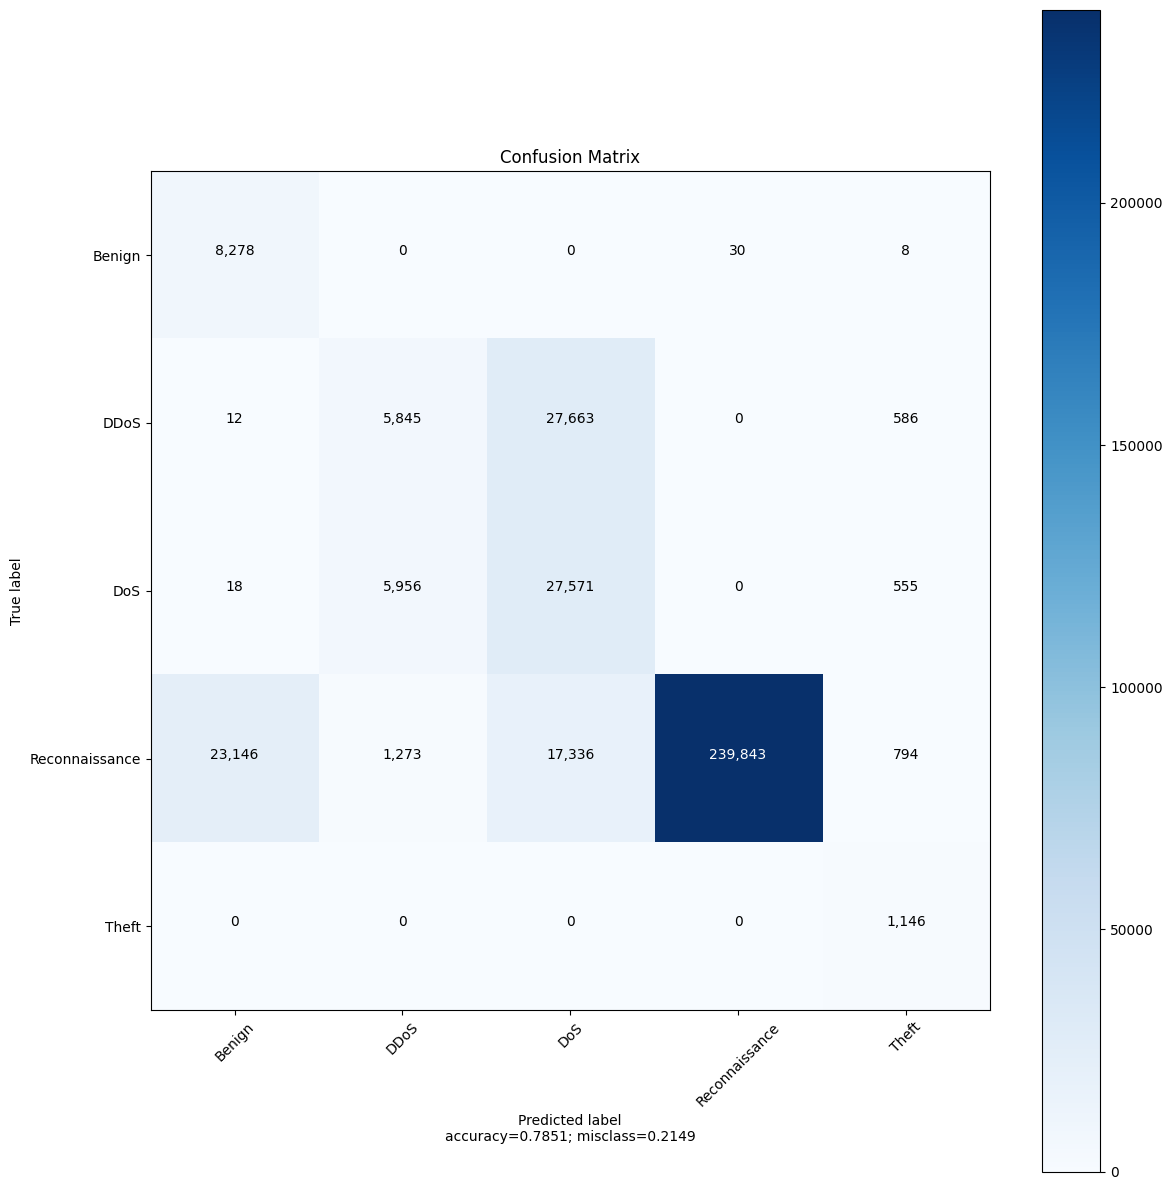

In [ ]:
# Importing confusion_matrix from scikit-learn
from sklearn.metrics import confusion_matrix
# Plotting the confusion matrix using the custom function
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")